In [79]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

sns.set(context='talk', style='white')

study_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CRAB/CRAB_lab/studies/crab-seal_hbcdmovies_pilot_2025'
data_dir = os.path.join(study_dir, 'DATA','V1_motrak')
out_dir = os.path.join(study_dir, 'DATA','V1_motion_processed')
timing = pd.read_csv(os.path.join(study_dir, 'measures','clips','ClipTimingForAnalysis.csv'), index_col=0)

subIDs = ['2002']

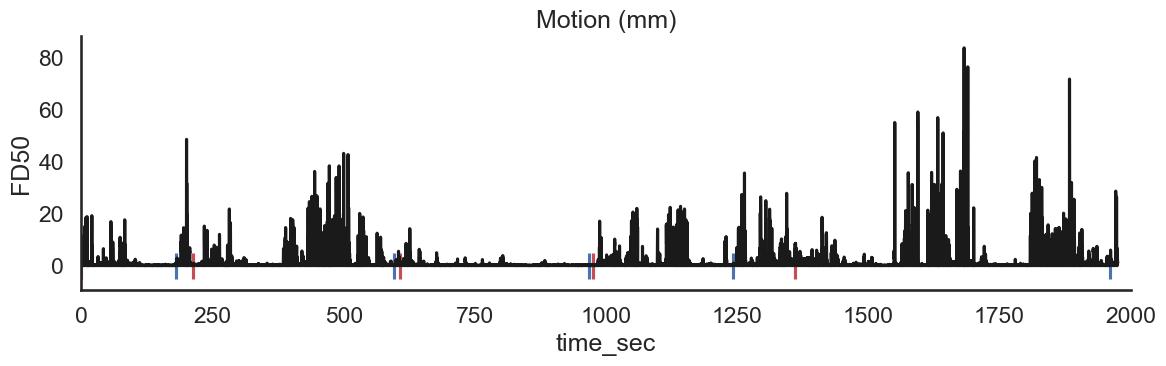

In [88]:
for sub in subIDs:
    os.makedirs(os.path.join(out_dir,sub),exist_ok=True)
    file = glob(os.path.join(data_dir, sub, '*.txt'))[0]
    motion = pd.read_csv(file, index_col=0, delimiter='\t')
    listnum = int(os.path.basename(file).split('_')[1][-1])
    versnum = int(os.path.basename(file).split('_')[2][-5])
    subtime = timing.loc[(timing['set']==listnum) & (timing['version']==versnum),:]

    # convert index to datetime then seconds
    origind = motion.index
    motion.index = pd.to_datetime(origind)
    zeroed_times = motion.loc[motion['Events']=='Zeroed',:].index.to_numpy()
    motion = motion.resample('100ms').mean()
    time = np.arange(0,len(motion)/10,0.1)
    motion.index = time
    motion.index.name = 'time_sec'

    # compute 1st derive of motion
    for a in motion.columns:
        motion.loc[:, '{0}1'.format(a)] = np.gradient(motion.loc[:,a])

    # compute FD (adult head size)
    motion.loc[:, 'FD50'] = np.sum(np.absolute(motion.loc[:,['X1','Y1','Z1']]),axis=1) + 50*(np.pi/180)*np.sum(np.absolute(motion.loc[:,['Pitch1','Yaw1','Roll1']]),axis=1)
    
    # summarize motion for each clip separately
    motion_summary = pd.DataFrame()
    for v in subtime.index:
        motion.loc[subtime.loc[v, 'start_sec']:subtime.loc[v, 'start_sec']+subtime.loc[v, 'duration_sec'],'title'] = v
        tempmotion = motion.loc[subtime.loc[v, 'start_sec']:subtime.loc[v, 'start_sec']+subtime.loc[v, 'duration_sec'],:]
        motion_summary.loc[v, 'meanFD'] = tempmotion['FD50'].mean(axis=0)
        motion_summary.loc[v, 'minFD'] = tempmotion['FD50'].min(axis=0)
        motion_summary.loc[v, 'maxFD'] = tempmotion['FD50'].max(axis=0)
        motion_summary.loc[v, 'sdFD'] = tempmotion['FD50'].std(axis=0)
        motion_summary.loc[v, 'pcent_volscens_0.9'] = np.mean(tempmotion['FD50']>0.9)

    motion.to_csv(os.path.join(out_dir,sub,'{0}_motion_data_processed.csv'.format(sub)))
    motion_summary.to_csv(os.path.join(out_dir,sub,'{0}_motion_summary.csv'.format(sub)))
    
    # plot overall motion
    fig, ax = plt.subplots(1,1,figsize=(12,4))

    motion.loc[:,'FD50'].plot(ax=ax, color='k')
    ax.vlines(timing['start_sec'].to_numpy(), ymin=-5, ymax=5, color='r')
    ax.vlines(timing['start_sec'].to_numpy()+timing['duration_sec'].to_numpy(), ymin=-5, ymax=5, color='b')
    sns.despine()
    plt.xlim(0,2000)
    plt.ylabel('FD50')
    plt.title('Motion (mm)')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, sub, '{0}_full_run_plot.png'.format(sub)), dpi=150)
    plt.show()
    plt.close()